In [48]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, LdaSeqModel
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
print(len(newsgroups_train.data))

3219


In [4]:
cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

In [5]:
np.set_printoptions(precision=3)

In [6]:
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10, topic_word_prior=1/n_components, doc_topic_prior=10/n_components, learning_method='batch', n_jobs=-1)

In [7]:
review_topics = lda.fit_transform(review_cv)

In [8]:
print(review_topics.shape)
print(review_topics[0])

(3219, 10)
[0.008 0.007 0.813 0.006 0.007 0.006 0.133 0.006 0.008 0.006]


In [9]:
gross_topic_weights = np.mean(review_topics, axis=0)
print(gross_topic_weights)

[0.081 0.062 0.137 0.092 0.08  0.131 0.162 0.096 0.056 0.102]


In [10]:
review_topics.shape

(3219, 10)

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [12]:
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: space, nasa, information, internet, faq, anonymous, gov, orbit, sci, data
Topic #1: space, launch, new, cost, year, nasa, gov, right, commercial, years
Topic #2: com, article, posting, nntp, host, just, don't, keith, think, access
Topic #3: com, university, posting, host, nntp, graphics, washington, computer, article, mail
Topic #4: com, just, know, jesus, like, good, brian, people, article, don't
Topic #5: image, software, version, file, graphics, files, windows, use, program, bit
Topic #6: god, people, don't, say, think, com, does, christian, believe, article
Topic #7: com, key, netcom, des, chip, keys, clipper, nsa, pgp, crypto
Topic #8: encryption, clipper, chip, government, law, use, key, technology, privacy, security
Topic #9: drive, scsi, ide, controller, disk, bus, hard, drives, com, university



n_components: 6, perplexity: 3283.435
n_components: 7, perplexity: 3259.015
n_components: 8, perplexity: 3211.871
n_components: 9, perplexity: 3273.342
n_components: 10, perplexity: 3240.417
n_components: 11, perplexity: 3246.680
n_components: 12, perplexity: 3267.414
n_components: 13, perplexity: 3307.195
n_components: 14, perplexity: 3309.275
n_components: 15, perplexity: 3329.700


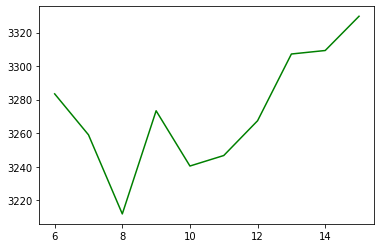

8

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [14]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: key, encryption, clipper, chip, government, use, public, security, keys, privacy
Topic #1: drive, scsi, card, university, ide, controller, disk, bus, hard, host
Topic #2: com, article, nntp, posting, host, i'm, just, netcom, like, don't
Topic #3: god, jesus, people, does, bible, believe, just, time, say, good
Topic #4: space, nasa, gov, information, research, center, faq, university, sci, 1993
Topic #5: space, article, launch, moon, orbit, access, nasa, just, earth, henry
Topic #6: graphics, image, file, files, software, ftp, version, program, mail, available
Topic #7: people, com, don't, article, think, say, keith, morality, just, like



In [15]:
reg_token = RegexpTokenizer("[\w']{3,}")
english_stops = set(stopwords.words('english'))

def tokenizer(text):
    tokens = reg_token.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

In [16]:
dictionary = Dictionary(texts)
print(len(dictionary))

dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print(len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print(len(dictionary), len(corpus))

46466
2000
2000 3219


In [17]:
num_topics = 10
passes = 5
model = LdaModel(corpus=corpus, id2word=dictionary,
                       passes=passes, num_topics=num_topics,
                       random_state=7)

In [18]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [19]:
model.get_document_topics(corpus)[0]

[(0, 0.72576934), (8, 0.2699505)]

In [20]:
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


In [23]:
df = pd.read_csv("./data/petition_sampled.csv")
df.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


In [25]:
okt = Okt()

In [26]:
def tokenizer(doc):
    return [token for token in okt.nouns(doc) if len(token) > 1]

In [28]:
cv = CountVectorizer(tokenizer=tokenizer, max_df=0.5, min_df=5, max_features=1000)
pet_cv = cv.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [29]:
lda = LatentDirichletAllocation(n_components=15, n_jobs=-1, random_state=0)

In [30]:
pet_topics = lda.fit_transform(pet_cv)

In [31]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(', '.join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

In [32]:
print_top_words(lda, cv.get_feature_names_out(), 15)

Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 대통령, 국민, 나라, 자신, 환자, 정말, 대한민국, 가족
Topic #1: 북한, 한국, 우리, 대통령, 정부, 대한민국, 미국, 국민, 문재인, 일본, 국가, 문제, 생각, 우리나라, 나라
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 출산, 아빠, 결혼
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 이용, 생각, 사찰, 게임, 노인, 사람, 사회, 축구, 나이
Topic #4: 주택, 정부, 정책, 부동산, 서민, 아파트, 국민, 나라, 세금, 대통령, 사람, 지금, 서울, 투기, 집값
Topic #5: 일자리, 정부, 기업, 생각, 근무, 지원, 근로자, 임금, 최저임금, 정책, 시간, 사람, 고용, 대기업, 직원
Topic #6: 국민, 청원, 국회의원, 국회, 난민, 의원, 대통령, 청와대, 정치, 세금, 반대, 생각, 나라, 대한민국, 국가
Topic #7: 관리, 대한, 내용, 판결, 관련, 공사, 조사, 업무, 판사, 확인, 사실, 결과, 기관, 해당, 경우
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 국민, 방송, 의료, 소득, 건강, 가입, 국가, 보험료, 기초, 제도
Topic #10: 여성, 공무원, 사회, 생각, 남성, 남자, 대한민국, 의무, 사람, 여자, 행정, 군대, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 만행, 경찰서, 범죄자, 수사, 부정부패, 검찰, 살인마
Topic #12: 처벌, 차량, 사건, 사고, 경우, 기사, 피해, 대한, 피해자, 안전, 행위, 이명박, 청원, 택시, 관련
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래, 시장, 계획, 규제, 주식, 

In [33]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.075431,0.178300,0.000307,0.000307,0.742581,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.169797,0.000813,0.000813,0.058154,0.000813,0.000813,0.000813,0.142041,0.070066,0.000813,0.000813,0.000813,0.551813,2017-08
2,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.979710,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.038665,0.670496,0.000227,0.000227,0.000227,0.231310,0.000227,0.000227,0.000227,0.000227,0.016086,0.000227,0.000227,0.000227,0.041175,2017-08
4,0.068176,0.344914,0.000447,0.000447,0.000447,0.033170,0.322260,0.000447,0.000447,0.000447,0.227005,0.000447,0.000447,0.000447,0.000447,2017-08


In [34]:
trend = trend_data.groupby(['start']).mean()
trend.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,,,,,,,,,,,
2017-08,0.077774,0.100127,0.152156,0.011585,0.059008,0.126860,0.035792,0.085492,0.096521,0.041937,0.031564,0.015125,0.032138,0.026306,0.107615
2017-09,0.148761,0.054678,0.088093,0.284642,0.030026,0.044347,0.050916,0.038872,0.056488,0.022204,0.041628,0.025142,0.053777,0.020606,0.039820
2017-10,0.105944,0.083196,0.063092,0.046101,0.054212,0.095063,0.056595,0.061956,0.083099,0.035336,0.084683,0.053623,0.057386,0.031646,0.088069
2017-11,0.129331,0.058988,0.043212,0.029472,0.038092,0.057070,0.095541,0.048153,0.066312,0.030609,0.045303,0.040608,0.229142,0.040015,0.048151
2017-12,0.118983,0.077071,0.064286,0.039208,0.055003,0.104068,0.087627,0.060753,0.072500,0.036061,0.055756,0.026878,0.071888,0.048763,0.081157


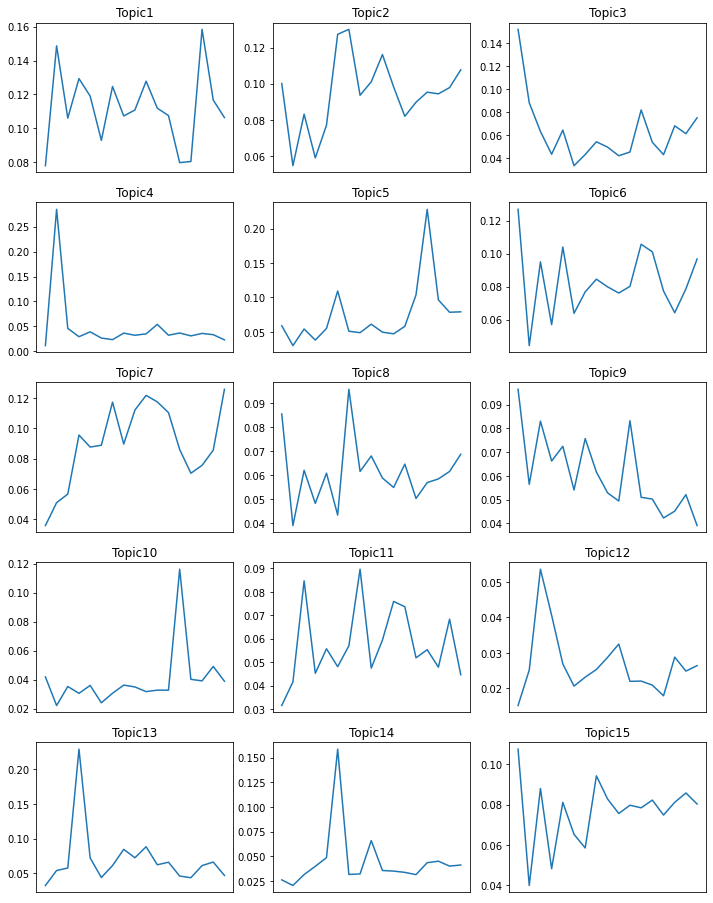

In [36]:
fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

In [37]:
df.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


In [38]:
df_sorted = df.sort_values(by='start')
df_sorted['time'] = df_sorted['start'].map(lambda x: x[:7])
df_sorted.head()

,article_id,start,end,answered,votes,category,title,content,time
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...,2017-08
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...,2017-08
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...,2017-08
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...,2017-08
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...,2017-08


In [40]:
time_slice = list(df_sorted['time'].value_counts().sort_index())
time_tag = sorted(list(set(df_sorted['time'])))

In [41]:
okt = Okt()

In [42]:
def tokenizer(doc):
    return [token for token in okt.nouns(doc) if len(token) > 1]

In [43]:
texts = [tokenizer(news) for news in df_sorted['content']]

In [44]:
dictionary = Dictionary(texts)
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)

In [45]:
corpus = [dictionary.doc2bow(text) for text in texts]
print(len(dictionary), len(corpus))

2000 18077


In [46]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

num_topics: 6, perplexity: -6.903, coherence: -2.204
num_topics: 7, perplexity: -6.885, coherence: -2.174
num_topics: 8, perplexity: -6.886, coherence: -2.181
num_topics: 9, perplexity: -6.875, coherence: -2.323
num_topics: 10, perplexity: -6.860, coherence: -2.298
num_topics: 11, perplexity: -6.863, coherence: -2.355
num_topics: 12, perplexity: -6.864, coherence: -2.616
num_topics: 13, perplexity: -6.872, coherence: -2.333
num_topics: 14, perplexity: -6.884, coherence: -2.439
num_topics: 15, perplexity: -6.946, coherence: -2.452


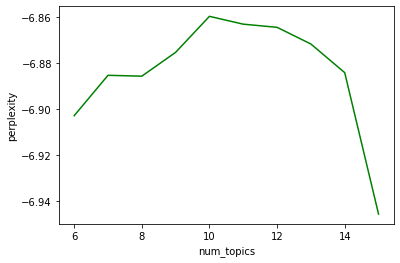

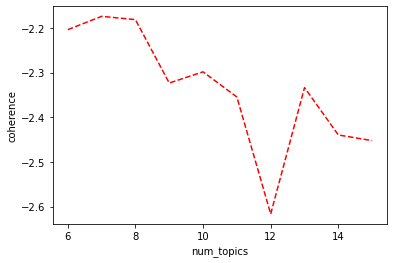

In [47]:
show_coherence(corpus, dictionary, start=6, end=15)

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=6, random_state=7)

In [ ]:
def get_topic_words(topic, top_n_words=10):
    words, _ = zip(*topic)
    return words[:top_n_words]

def print_topic_times(model, topic, time_tag, top_n_words=10):
    topic_times = model.print_topic_times(topic)
    for i in range(len(topic_times)):
        print(time_tag[i]+':', get_topic_words(topic_times[i], top_n_words))

In [ ]:
print_topic_times(ldaseq, 4, time_tag, 10)

In [ ]:
def get_topic_trends(model, corpus, time_slice):
    dtm = model.dtm_vis(0, corpus)
    result = []
    start = 0
    for index in time_slice:
        result.append(np.array(dtm[0][start:start+index]).mean(axis=0))
        start += index
    return np.array(result)

In [ ]:
topic_trends = get_topic_trends(ldaseq, corpus, time_slice)

In [ ]:
topic_titles = ['Topic '+str(i) for i in range(6)] # 토픽 타이틀 생성
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12, 6)) 
for i, (title, ax) in enumerate(zip(topic_titles, axes.ravel())): 
    ax.set_title(title)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels(time_tag[::5])
    ax.plot(topic_trends[:, i])
plt.show()